# Pneumonia Detection
Nowadays, there are numerous studies which center on how computer-based decision procedures, under the broad umbrella of AI, can assist in improving health and health care. Major scientific competitions like ImageNet Large Scale Visual recognition Challenges are providing evidence that computer can achieve human-like competence in image recognition. So why not assist a patient and diagnose his condition with the help of a few clicks.<br>
In this notebook, we will discuss about one such application Pneumonia Detection.<br>
<br>
## Agenda
- Analyze and Process Dataset
- Build a custom Image Classifier
- Transfer Learning on InceptionV3
- Results and Data Visaulization

Let's get started!!
Data for this demonstration can be found [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

### Import Libraries

In [1]:
import sys
import os
import argparse
import random

import time
import datetime

from collections import Counter

import numpy as np
import pandas as pd

import shutil
from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image
import cv2

import keras

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense

from keras.applications.inception_v3 import InceptionV3
from keras import backend as K

from keras.constraints import maxnorm


from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import class_weight


from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf



from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

Using TensorFlow backend.


### Utility Functions for Plotting Image

In [2]:
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

In [5]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
  
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}

    plot_params["figsize"] = figsize

    plot_params["title"] = title

    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel

    plot_params["legends"] = legends 

    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize

    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image

    plot_params["subplot"] = None
    return plot_params

def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)
    image_file_paths = {}
    for i in range(class_count):
        subdir_path = os.path.join(image_dir, classes[i])
        subdir_files = os.listdir(subdir_path)
        sampled_files = random.sample(subdir_files, image_count_per_category)
        for j in range(len(sampled_files)):
            full_path = os.path.join(image_dir, classes[i], sampled_files[j])
            sampled_files[j] = full_path
        image_file_paths[classes[i]] = sampled_files

    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])

    return fig, axs
    

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])

        i=i+1

    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])

    plt.tight_layout()
    plt.show()

    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)

In [6]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)

    return subdirectory_names, subdirectory_file_counts

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [8]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    tf.reset_default_graph()   
    K.clear_session()
    gc.collect()
    return True

# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

### Visualize Data

In [9]:
reset_graph()
reset_callbacks()

In [10]:
# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = "chest_xray"
output_directory = "models"

training_dir = os.path.join(input_directory, "train")
validation_dir = os.path.join(input_directory, "val")
testing_dir = os.path.join(input_directory, "test")

Number of Class:  2
-------------------------------------------------------Pneumonia-------------------------------------------------------


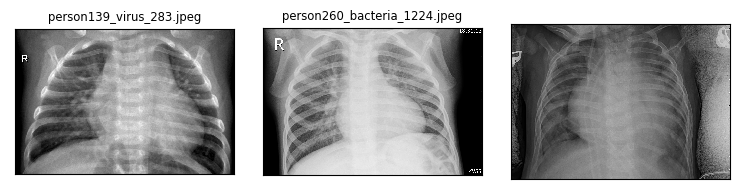

-------------------------------------------------------Normal-------------------------------------------------------


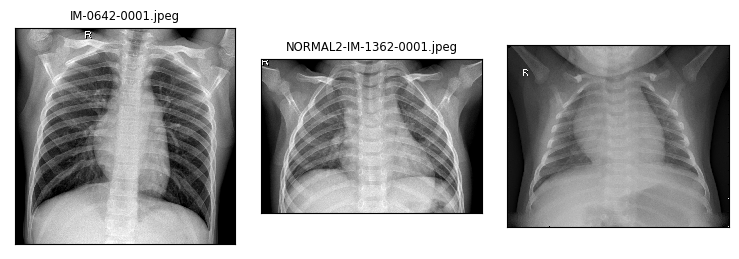

In [11]:
show_class_sample_images(training_dir, image_count_per_category=3, save=False, dpi=100, update_image=False)

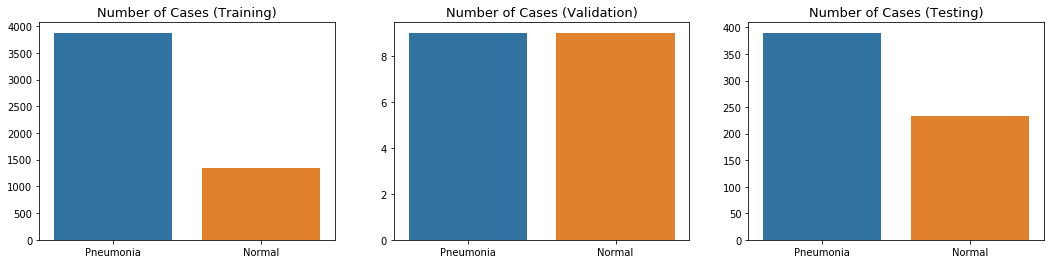

In [12]:
plot_params = get_reset_plot_params()

plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10

plot_params['title'] = "Number of Cases"

plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = os.listdir(training_dir)
classes = [name_correct(i) for i in classes]

### Reading data using TF ImageDataGenerator

In [13]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"
#class_mode = "binary"

train_datagen = ImageDataGenerator(
  rescale=rescale,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
  training_dir,
  target_size=target_size,
  class_mode=class_mode,
  batch_size=50,
  shuffle=True)

validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  target_size=target_size,
  class_mode=class_mode,
  batch_size=2,
  shuffle = False)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
  testing_dir,
  target_size=target_size,
  class_mode=class_mode,
  batch_size=20,
  shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [15]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

### Callbacks

In [17]:
main_model_dir = os.path.join(output_directory, "models")
main_log_dir = os.path.join(output_directory, "logs")
model_file = main_model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

checkpoint = ModelCheckpoint(
  model_file, 
  monitor='val_acc', 
  save_best_only=False)

early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=5,
  verbose=1,
  restore_best_weights=True)

tensorboard = TensorBoard(
  log_dir=main_log_dir,
  batch_size=batch_size,
  update_freq = 'batch')

reduce_lr = ReduceLROnPlateau(
  monitor='val_loss',
  patience=5,
  cooldown=2,
  min_lr=0.0000000001,
  verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]

### Custom Model

In [18]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(150,150,3)))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    #model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    #model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    #model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    #model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 , activation='softmax'))

    return model

In [19]:
model = get_conv_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5760064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

In [20]:
steps_per_epoch=105
validation_steps=8

optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 10

model.compile(optimizer, loss=loss, metrics=metrics)

In [23]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = steps_per_epoch,
  epochs=epochs,
  verbose=1,
  callbacks=callbacks,
  validation_data=validation_generator,
  validation_steps=validation_steps, 
  class_weight=class_weight)

Epoch 1/10
105/105 [==============================] - 59s 564ms/step - loss: 0.6273 - acc: 0.7845 - val_loss: 0.5531 - val_acc: 0.8125
Epoch 2/10
105/105 [==============================] - 56s 529ms/step - loss: 0.2668 - acc: 0.8891 - val_loss: 0.5863 - val_acc: 0.7500
Epoch 3/10
105/105 [==============================] - 56s 537ms/step - loss: 0.2627 - acc: 0.8929 - val_loss: 0.7008 - val_acc: 0.6875
Epoch 4/10
105/105 [==============================] - 59s 558ms/step - loss: 0.2375 - acc: 0.9083 - val_loss: 0.7157 - val_acc: 0.7500
Epoch 5/10
105/105 [==============================] - 57s 539ms/step - loss: 0.2230 - acc: 0.9131 - val_loss: 0.6569 - val_acc: 0.7500
Epoch 6/10
105/105 [==============================] - 57s 540ms/step - loss: 0.2083 - acc: 0.9268 - val_loss: 0.3175 - val_acc: 0.8750
Epoch 7/10
105/105 [==============================] - 58s 551ms/step - loss: 0.2070 - acc: 0.9249 - val_loss: 0.5466 - val_acc: 0.7500
Epoch 8/10
105/105 [==============================] - 5

### Transfer Learning with InceptionV3

In [21]:
def get_inception_model():    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    x = base_model.output
    # x = Dropout(0.5)(x)
    # x = GlobalAveragePooling2D()(x)
    # x = Dense(512, activation='relu')(x)
    # x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    # predictions = Dense(2, activation='sigmoid')(x) 
    predictions = Dense(2, activation='softmax')(x) 
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False    
    #     for layer in model.layers[:249]:
    #         layer.trainable = False
    #     for layer in model.layers[249:]:
    #         layer.trainable = True

    return model

In [22]:
inception_model = get_inception_model()
inception_model.summary()

87916544/87910968 [==============================] - 50s 1us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________

In [24]:
steps_per_epoch=105
validation_steps=8

optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 100

inception_model.compile(optimizer, loss=loss, metrics=metrics)

In [25]:
history = inception_model.fit_generator(
  train_generator,
  steps_per_epoch = steps_per_epoch,
  epochs=epochs,
  verbose=1,
  callbacks=callbacks,
  validation_data=validation_generator,
  validation_steps=validation_steps)

Epoch 1/100
105/105 [==============================] - 59s 562ms/step - loss: 0.4769 - acc: 0.8803 - val_loss: 4.4022 - val_acc: 0.6250
Epoch 2/100
105/105 [==============================] - 51s 486ms/step - loss: 0.4426 - acc: 0.9054 - val_loss: 7.0450 - val_acc: 0.5000
Epoch 3/100
105/105 [==============================] - 55s 524ms/step - loss: 0.4531 - acc: 0.9135 - val_loss: 3.8117 - val_acc: 0.7500
Epoch 4/100
105/105 [==============================] - 58s 557ms/step - loss: 0.4038 - acc: 0.9156 - val_loss: 4.4428 - val_acc: 0.6250
Epoch 5/100
105/105 [==============================] - 56s 530ms/step - loss: 0.4058 - acc: 0.9181 - val_loss: 2.1901 - val_acc: 0.7500
Epoch 6/100
105/105 [==============================] - 61s 585ms/step - loss: 0.4005 - acc: 0.9225 - val_loss: 4.2490 - val_acc: 0.6875
Epoch 7/100
105/105 [==============================] - 58s 554ms/step - loss: 0.4417 - acc: 0.9221 - val_loss: 7.2150 - val_acc: 0.5000
Epoch 8/100
105/105 [===========================

### Results and Data Visualization

To view model in tensorboard run the following cell in shell<br>
*tensorboard --logdir logs*

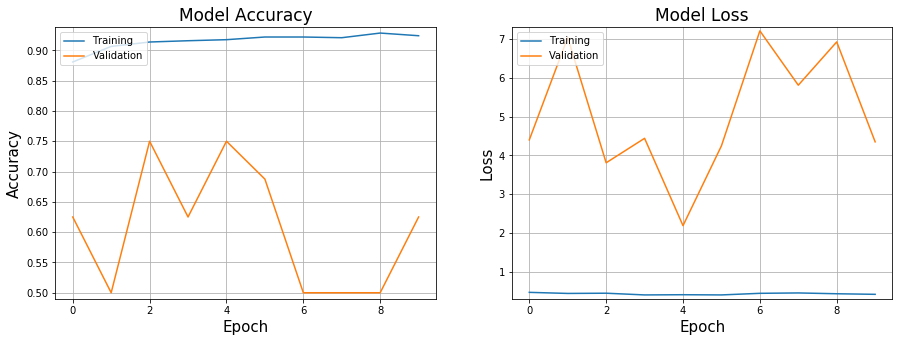

In [26]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [28]:
result  = inception_model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

32/32 [==============================] - 8s 259ms/step
Loss     : 2.65  
Accuracy : 70.99%


Seems like we need more validation data to improve performance!<br>
For now, let's use the custom model to make predictions.

In [29]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

32/32 [==============================] - 5s 141ms/step


Text(0.5, 1.05, 'Confusion Matrix')

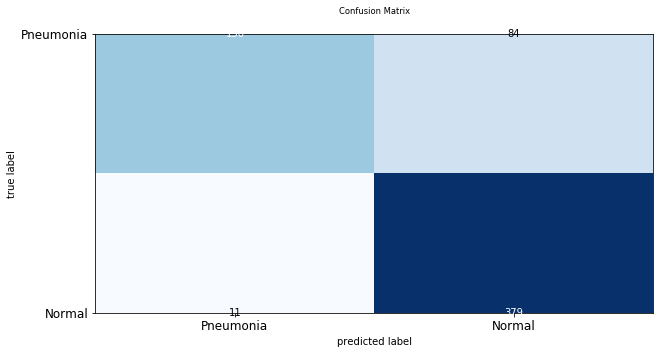

In [31]:
precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred)
CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,10), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix")

In [40]:
cls_report = classification_report(y_true, y_pred, target_names=classes)
print(cls_report)

              precision    recall  f1-score   support

   Pneumonia       0.93      0.64      0.76       234
      Normal       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.82       624
weighted avg       0.86      0.85      0.84       624



In [70]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 1
-----------------------------------
Batch Size              : 20
-----------------------------------
Accuracy                : 84.78%
-----------------------------------


In [71]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"/"+ file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
    print("Prediction Plot")
    plt.tight_layout()
    plt.show()

In [72]:
batch_size_t = len(y_true_batch)
class_map = {v: k for k, v in test_generator.class_indices.items()}
dpi=100
ncols = 5
nrows = 4
count = ncols*nrows
subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

Prediction Plot


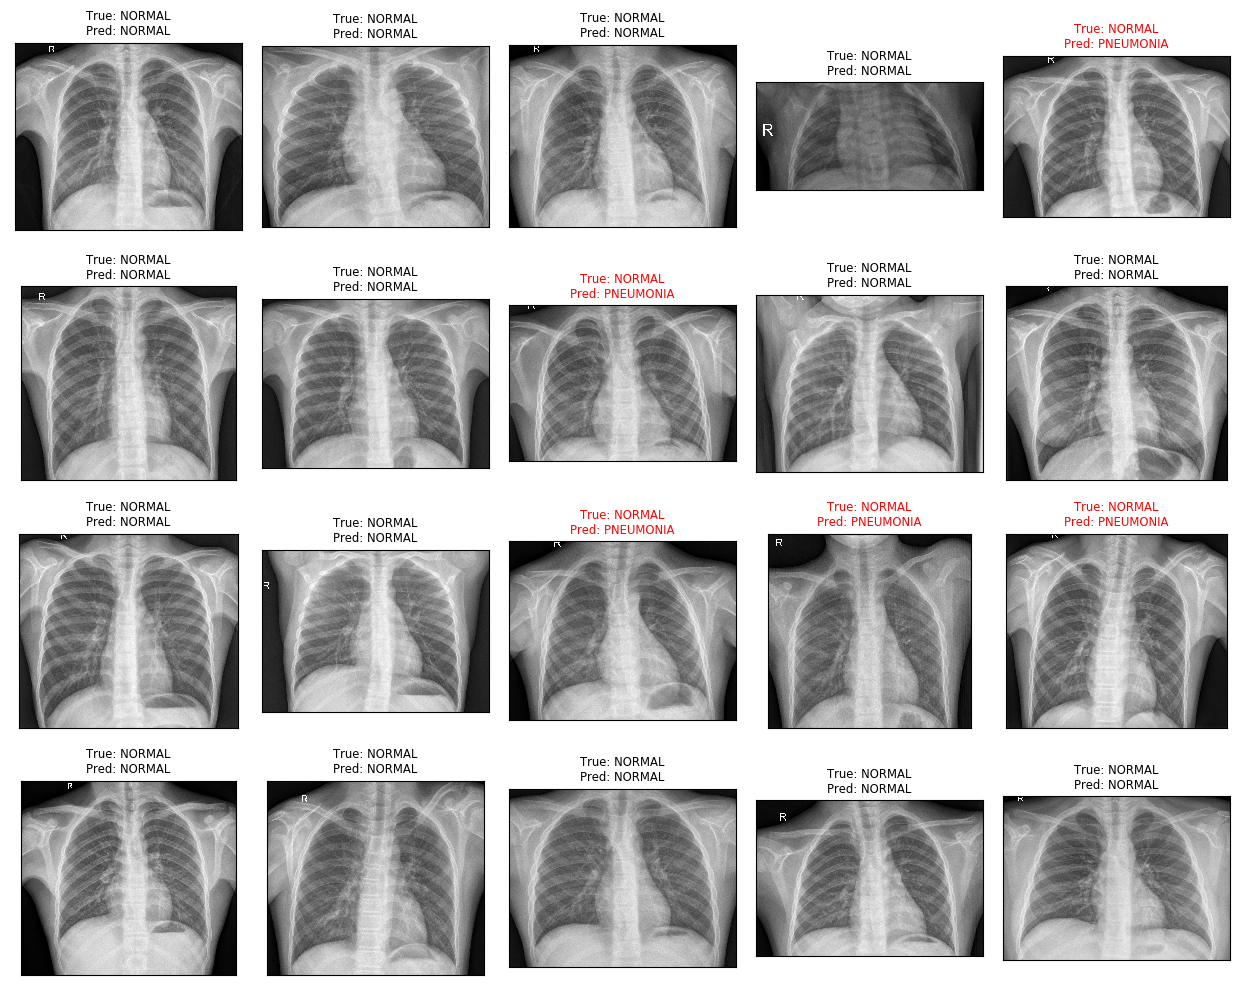

In [74]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, count=count, sample=True)

# Acknowledgement
[Detection of Pneumonia from Chest X-Ray Images](https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning/blob/master/code/Detection%20of%20Pneumonia%20from%20Chest%20X-Ray%20Images%201.0.0.3.ipynb) by Anjana Tiha